# TDS Why you should try Bayesian AB Testing <a id="two"></a>
- https://towardsdatascience.com/why-you-should-try-the-bayesian-approach-of-a-b-testing-38b8079ea33a
- https://github.com/michaelarman/Bayesian_A-B_testing/blob/master/Bayesian%20AB%20testing.ipynb

## Import Libraries

In [26]:
import pandas as pd
import pymc3 as pm
import numpy as np
import theano.tensor as tt
from IPython.core.pylabtools import figsize
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

pm.__version__

'3.11.2'

## Import Data

In [2]:
df = pd.read_csv('C:\\Users\\wallj\\DS_Projects\\DataScience\\Datasets\\cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Feature Analysis

In [9]:
df['retention_1'] = np.where(df['retention_1']==True,1,0)
df['retention_7'] = np.where(df['retention_7']==True,1,0)

In [11]:
site_A = df[df['version'] == 'gate_30']
site_B = df[df['version'] == 'gate_40']

<AxesSubplot:xlabel='retention_1', ylabel='Density'>

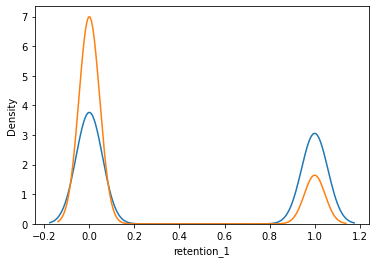

In [12]:
# Graph distributions
sns.kdeplot(data=site_A,x='retention_1')
sns.kdeplot(data=site_A,x='retention_7')
# Hey look at that! They go on the same chart!

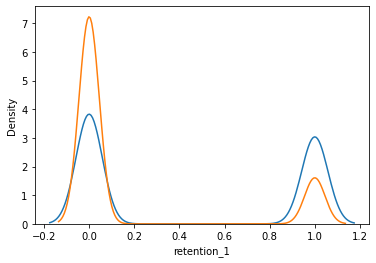

In [13]:
sns.kdeplot(site_B['retention_1']);
sns.kdeplot(site_B['retention_7']);

In [14]:
# group by the version to see the sample size of each variant - we'll use these counts in the inference
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


In [15]:
N_A = 44700
N_B = 45489

observations_A = df[df['version'] == 'gate_30']['retention_1'].values.astype(int)
observations_B = df[df['version'] == 'gate_40']['retention_1'].values.astype(int)

print('The number of users retained after 1 day in variant A:', observations_A.sum())
print('The number of users retained after 1 day in variant B:', observations_B.sum())

The number of users retained after 1 day in variant A: 20034
The number of users retained after 1 day in variant B: 20119


In [16]:
# Summary Table
df.groupby('version').mean()[['retention_1','retention_7']]

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


## Bayesian Modeling

In [37]:
#these two quantities are unknown to us. And you can assume the values
true_p_A = 0.45
true_p_B = 0.40

# Set up the pymc3 model. Assume Beta priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Beta("p_A", 11, 14) #11 successes and 14 failures
    p_B = pm.Beta("p_B", 11, 14)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets (the two variants).
    # this is the likelihood function where we use the prior distribution as our parameter in the likelihood function
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    
    step = pm.Metropolis()
    # trace = pm.sample(draws=20000,step=step) # sample 20000 iterations and store the paths of all our variables, or "traces"
    trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)
    burned_trace=trace[1000:] # discard the first 1000 iterations

C:\Users\wallj\AppData\Local\Temp\ipykernel_16296\1233979402.py:22: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=50000, step=pm.Metropolis(), start=pm.find_MAP(), progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


Sampling 4 chains for 1_000 tune and 50_000 draw iterations (4_000 + 200_000 draws total) took 401 seconds.


MemoryError: Unable to allocate 16.7 GiB for an array with shape (50000, 44700) and data type float64

In [ ]:
# Grab samples from the burned trace
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

In [ ]:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that variant A is worse than variant B.
print("Probability site A is WORSE than site B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probability site A is BETTER than site B: %.3f" % \
    np.mean(delta_samples > 0))

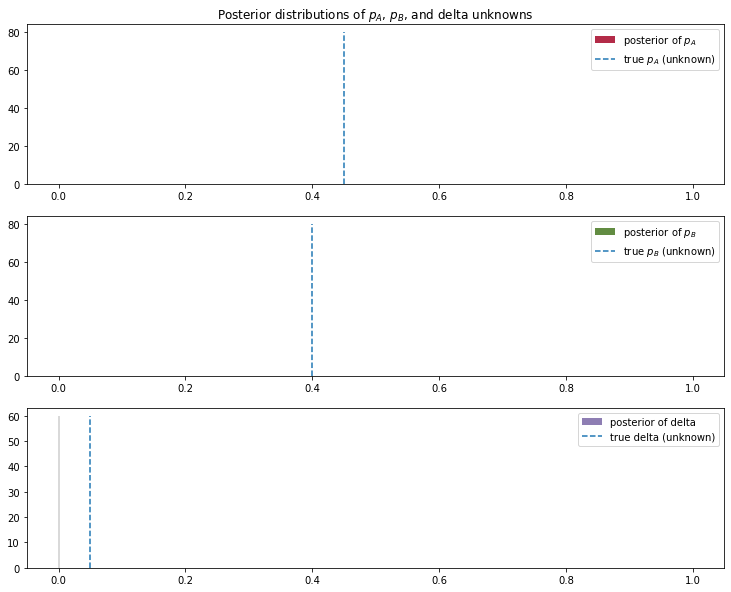

In [24]:
figsize(12.5, 10)

#histogram of posteriors

ax = plt.subplot(311)

# plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_A$", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="true $p_A$ (unknown)")
plt.legend(loc="upper right")
plt.title("Posterior distributions of $p_A$, $p_B$, and delta unknowns")

ax = plt.subplot(312)

# plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
         label="posterior of $p_B$", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="true $p_B$ (unknown)")
plt.legend(loc="upper right")

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--",
           label="true delta (unknown)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.legend(loc="upper right");